# WGAN on MNIST 

# Import 

In [1]:
''' basic package '''
import os
# 告訴系統要第幾張卡被看到。 Ex. 硬體總共有8張顯卡，以下設定只讓系統看到第1張顯卡
# 若沒設定，則 Tensorflow 在運行時，預設會把所有卡都佔用
# 要看裝置內顯卡數量及目前狀態的話，請在終端機內輸入 "nvidia-smi"
# 若你的裝置只有一張顯卡可以使用，可以忽略此設定
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


# Config 

In [2]:
batch_size = 128
Z_dim = 100        # demesion of noise vector z for generator input
max_iter = 1000000
mnist = input_data.read_data_sets('/data/examples/MNIST_data', one_hot=True)

Extracting /data/examples/MNIST_data/train-images-idx3-ubyte.gz
Extracting /data/examples/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /data/examples/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /data/examples/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
learning_rate = 0.001
clip = [-0.01, 0.01]
D_update_cycle = 5

# Train 

### 定義 generator & discriminator 

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

#### Define model ####
def generator(z):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope('hidden_layer'):
            G_W1 = tf.get_variable(name='weight_1', dtype=tf.float32, initializer=xavier_init([100, 128]))
            G_b1 = tf.get_variable(name='bias_1', dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)

        with tf.variable_scope('output_layer'):
            G_W2 = tf.get_variable(name='weight_2', dtype=tf.float32, initializer=xavier_init([128, 784]))
            G_b2 = tf.get_variable(name='bias_2', dtype=tf.float32, initializer=tf.zeros(shape=[784]))
            G_prob = tf.nn.sigmoid(tf.matmul(G_h1, G_W2) + G_b2)

    return G_prob

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('hidden_layer'):
            D_W1 = tf.get_variable(name='weight_1', dtype=tf.float32, initializer=xavier_init([784, 128]))
            D_b1 = tf.get_variable(name='bias_1', dtype=tf.float32, initializer=tf.zeros(shape=[128]))
            D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)

        with tf.variable_scope('output_layer'):
            D_W2 = tf.get_variable(name='weight_2', dtype=tf.float32, initializer=xavier_init([128, 1]))
            D_b2 = tf.get_variable(name='bias_2', dtype=tf.float32, initializer=tf.zeros([1]))
            D_logit = tf.matmul(D_h1, D_W2) + D_b2

    return D_logit


### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行



In [5]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
   #### placeholder ####
    Z = tf.placeholder(name='z', dtype=tf.float32, shape=[None, 100])                # generator input
    input_img = tf.placeholder(name='real_img', dtype=tf.float32, shape=[None, 784]) # discriminator input

    #### GAN model output ####  
    G_sample = generator(Z)
    D_logit_real = discriminator(input_img)
    D_logit_fake = discriminator(G_sample)

    #### loss ####
    D_loss_real = tf.reduce_mean(tf.scalar_mul(-1, D_logit_real))
    D_loss_fake = tf.reduce_mean(D_logit_fake)
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(tf.scalar_mul(-1, D_logit_fake))

        
    #### variable list ####
    varList = tf.trainable_variables()
    G_varList = [var for var in varList if 'generator' in var.name]
    D_varList = [var for var in varList if 'discriminator' in var.name]
    
    #### update ####
    D_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(D_loss, var_list=D_varList)
    G_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(G_loss, var_list=G_varList)
    
    clip_D_opt = [var.assign(tf.clip_by_value(var, clip[0], clip[1])) for var in D_varList]

    init = tf.global_variables_initializer()

### Tensorflow- 初始化模型

In [6]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [7]:
def sample_Z(m, n):
        return np.random.uniform(-1., 1., size=[m, n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

Iter: 0
D loss: -0.007447
G_loss: 0.01228


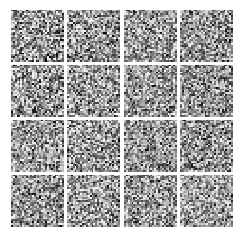

############################
Iter: 1000
D loss: -0.05841
G_loss: -0.02212


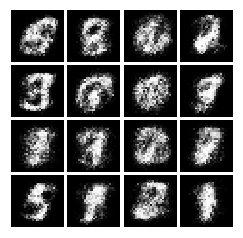

############################
Iter: 2000
D loss: -0.02524
G_loss: -0.01744


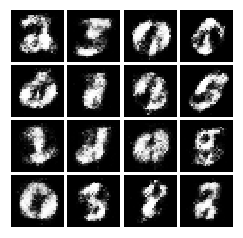

############################
Iter: 3000
D loss: -0.01889
G_loss: -0.01433


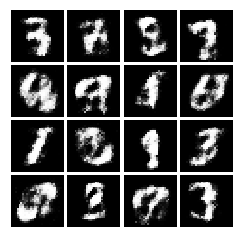

############################
Iter: 4000
D loss: -0.01924
G_loss: -0.02726


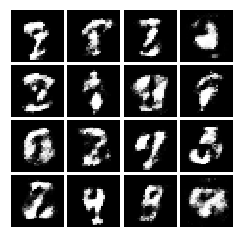

############################
Iter: 5000
D loss: -0.009909
G_loss: -0.007036


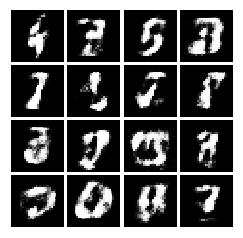

############################
Iter: 6000
D loss: -0.01032
G_loss: -0.01989


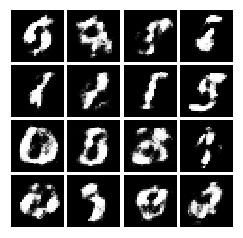

############################
Iter: 7000
D loss: -0.01432
G_loss: -0.02871


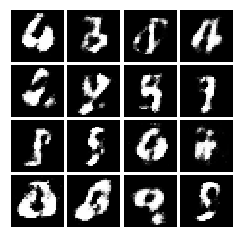

############################
Iter: 8000
D loss: -0.01081
G_loss: -0.01744


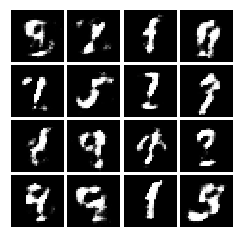

############################
Iter: 9000
D loss: -0.002109
G_loss: -0.01534


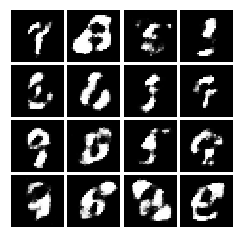

############################


KeyboardInterrupt: 

In [8]:
for it in range(max_iter):
    
    #### train ####
    for _ in range(D_update_cycle):
        X, _ = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={input_img: X, Z: sample_Z(batch_size, Z_dim)})
        sess.run(clip_D_opt)

    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)}) 

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
                                     
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.show()
        plt.close(fig)
        print('############################')
                                     
                                     